In [74]:
!pip install -q torch-audiomentations
!pip install -q torchaudio
!pip install -q julius

In [1]:
import platform
os_name = platform.system()

import numpy as np
from glob import glob
from IPython.display import Audio
import torch
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [2]:
speak_files=glob("cv-corpus-9.0-2022-04-27/zh-TW/clips/*.mp3")
firetruck_files=glob("sounds/firetruck/*.wav")
construction_files=glob("sounds/splited_construction/*.wav")
print(
    "#人聲:",len(speak_files),
    "\n#消防車聲:",len(firetruck_files),
    "\n#工地聲:",len(construction_files)
)

#人聲: 116969 
#消防車聲: 200 
#工地聲: 11997


In [3]:
SEED=28
SAMPLE_RATE=16000
kwargs=dict(
    sr=SAMPLE_RATE,
    mono=True
)
# x_signal,_=librosa.load(speak_files[SEED],**kwargs)
# x_artifact,_=librosa.load(firetruck_files[SEED],**kwargs)
# x_noise,_=librosa.load(construction_files[4],**kwargs)

In [135]:
from torch_audiomentations import Compose, Gain,PitchShift,Shift,AddBackgroundNoise
not_signal_kwargs={"sample_rate":SAMPLE_RATE,
            "mode":"per_example",
            "p":1.}
artifact_noise_transform=Compose(
    transforms=[
    PitchShift(# Pitch shift (frequency) without changinng meaning
                    min_transpose_semitones= -4.0, 
                    max_transpose_semitones= +1.0,
                    **not_signal_kwargs),
    Shift( # Waveform time shift (ratio) without changing shape
        min_shift=-0.5,
        max_shift=0.5,
        **not_signal_kwargs),
    Gain( # louder or quieter
        min_gain_in_db=-20.0,
        max_gain_in_db=-5.0,
        **not_signal_kwargs),
    ]
)

signal_kwargs={"sample_rate":SAMPLE_RATE,
            "mode":"per_example",
            "p":0.5}
transform = Compose(
    transforms=[
        PitchShift(# Pitch shift (frequency) without changinng meaning
            min_transpose_semitones= -4.0, 
            max_transpose_semitones= +4.0, 
            **signal_kwargs),
        Shift( # Waveform time shift (ratio) without changing shape
            min_shift=-0.8,
            max_shift=0.8,
            **signal_kwargs),
        Gain( # louder or quieter
            min_gain_in_db=-5.0,
            max_gain_in_db=10.0,
            **signal_kwargs),
    ]
)

In [136]:
import torch.utils.data as tud
import torchaudio
from julius.resample import ResampleFrac
if os_name=="Linux":
    torchaudio.set_audio_backend("sox_io") # for Linux system
    

class SyntheticCallDataset(tud.IterableDataset):
    def __init__(self,
                 signal_files,
                 artifact_files,
                 noise_files,
                 signal_len,
                 transform=None,
                 artifact_transform=None,
                 noise_transform=None):
        super().__init__()
        self.device=torch.device("cuda")
        self.signal_files=signal_files
        self.artifact_files=artifact_files
        self.noise_files=noise_files
        self.signal_len=signal_len
        # Initialize augmentation callable
        self.transform=transform
        self.artifact_transform = artifact_transform
        self.noise_transform = noise_transform
        # Resamplers for Frequency alignment
        self.resamp_32Kto16K=ResampleFrac(32000,16000).to(self.device)
        self.resamp_48Kto16K=ResampleFrac(48000,16000).to(self.device)
        self.resamp_44Kto16K=ResampleFrac(44100,16000).to(self.device)
        # Resamplers for synthetic signal generation
        self.resamp_16Kto8K=ResampleFrac(16000,8000).to(self.device)
    def __len__(self):
        return len(self.signal_files)
    def load_waveform(self,fname,transform=None):
        # Load data
        x_,sr_orig=torchaudio.load(fname,normalize=True)
        # Extend channel
        if x_.shape[0]==1:
            x_=torch.cat((x_,x_),dim=0)
        # Resample
        if sr_orig==16000:
            x_=x_.to(self.device)
        elif sr_orig==48000:
            x_=self.resamp_48Kto16K(x_.to(self.device))
        elif sr_orig==44100:
            x_=x_.to(torch.float32)
            x_=self.resamp_44Kto16K(x_.to(self.device))
        elif sr_orig==32000:
            x_=self.resamp_32Kto16K(x_.to(self.device))
        else:
            assert sr_orig in [48000,44100,32000], "Unsupported Sample Rate"
        ## Augmentation    
        if transform:
            x_=transform(x_[None,...])[0]
        ## Padding if needed
        if len(x_[0])<self.signal_len:
            x=torch.zeros((2,self.signal_len),dtype=torch.float32,device=self.device)
            start_point=np.random.randint(0,self.signal_len-len(x_[0]))
            end_point=start_point+len(x_[0])
            x[:,start_point:end_point]=x_
        else:
            x=x_[:,:self.signal_len]
        return x
        
    def __iter__(self):
        # Random choice of signal, artifact, noise combinations
        signal_files=np.random.permutation(self.signal_files)
        artifact_files=np.random.choice(self.artifact_files, size=len(self),replace=True)
        noise_files=np.random.choice(self.noise_files, size=len(self),replace=True)
        
        for fname_s,fname_a,fname_n in zip(signal_files[:360], artifact_files[:360],noise_files[:360]):
            ##### Loading waveforms #####
            # Load Signal
            signal=self.load_waveform(fname_s,self.transform)
            # Load artifact
            artifact=self.load_waveform(fname_a,self.artifact_transform)
            # Load Noise
            noise=self.load_waveform(fname_n,self.noise_transform)
            
            yield signal,artifact,noise
    def collate_fn(self,batch):
        signal,artifact,noise=[torch.stack([b[i] for b in batch],dim=0) for i in range(3)] 
        # Synthesize
        x=self.resamp_16Kto8K(signal+artifact+noise)
        return x,signal,artifact,noise

In [137]:
train_ds=SyntheticCallDataset(speak_files,
                              artifact_files=firetruck_files,
                              noise_files=construction_files,
                              signal_len=16000*4,
                              transform=transform,
                              artifact_transform=artifact_noise_transform,
                              noise_transform=artifact_noise_transform)

In [138]:
train_dl=tud.DataLoader(train_ds,batch_size=8,collate_fn=train_ds.collate_fn)

In [150]:
%%time
for  x,signal,artifact,noise in train_dl:
    break

CPU times: user 609 ms, sys: 0 ns, total: 609 ms
Wall time: 676 ms


In [158]:
BATCH_SEED=1
Audio(x[BATCH_SEED].cpu() ,rate=8000,normalize=True)

In [156]:
Audio(signal[BATCH_SEED].cpu() ,rate=16000,normalize=False)

In [146]:
Audio(artifact[BATCH_SEED].cpu() ,rate=16000,normalize=False)

In [147]:
Audio(noise[BATCH_SEED].cpu() ,rate=16000,normalize=False)

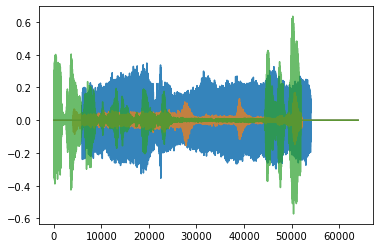

In [157]:
BATCH_SEED=1
plt.plot(artifact[BATCH_SEED,0].cpu().numpy().T,alpha=0.9)
plt.plot(noise[BATCH_SEED,0].cpu().numpy().T,alpha=0.7)
plt.plot(signal[BATCH_SEED,0].cpu().numpy().T,alpha=0.7)

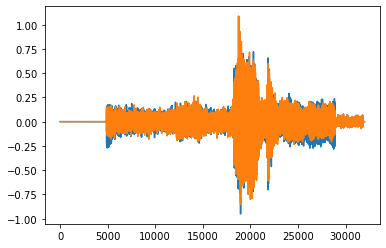

In [143]:
plt.plot(x[2,:].cpu().numpy().T)

In [15]:
# Setup common parameters for augmentation functions



In [12]:
import torchaudio

In [5]:
torchaudio.__version__

'0.9.0'

In [ ]:
https://pytorch.org/audio/0.11.0/models.html

In [16]:
samples1, _ = librosa.load(noise[0][0],
                           sr=SAMPLE_RATE,
                           mono=False)
samples1=torch.from_numpy(samples1[None,...])

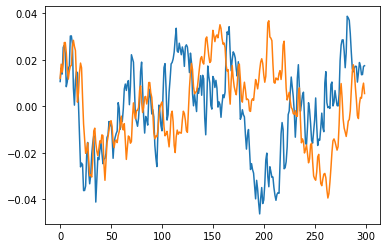

In [17]:
plt.plot(samples1[0,0,:300].T)
plt.plot(transform_siren(samples1)[0,0,:300].T)
plt.show()

In [47]:
torchaudio.load('cv-corpus-9.0-2022-04-27/zh-TW/clips/common_voice_zh-TW_30673318.mp3')

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0015, -0.0013, -0.0009]]), 32000)

In [42]:
Audio(data,rate=sr)

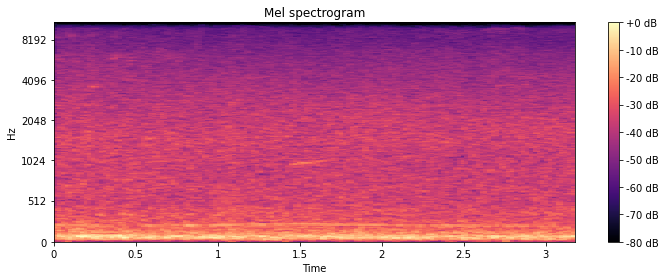

In [31]:
see_spectrum(samples1[0,0].numpy())

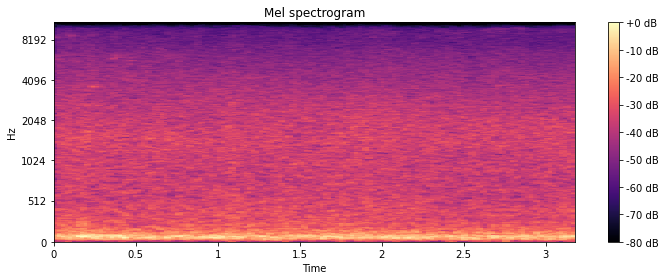

In [32]:
see_spectrum(samples1[0,1].numpy())

In [34]:
Audio(samples1[0,1],rate=SAMPLE_RATE)